## Overview
In this notebook, a new iterative approach was proposed for finding the shortest Euclidean distance between two <font color='red'>non-overlapping</font> point clouds.  
Basic idea:
1. Pick up a point A from the 1st point cloud
2. Find the closest point of A in the 2nd point cloud, which is denoted as B
3. Find the closest point of B in the 1st point cloud, which is denoted as A'
4. If A == A', the shortest distance between the two point clouds is defined by the vector connecting A to B.
5. If A != A', repeat the process of step 1 to 3

Compared to the exhaustive search using kd-tree, the new approach ~ 5 to 10 times faster...

In [12]:
import time

from scipy import spatial

import numpy as np
import matplotlib.pyplot as plt

In [13]:
def find_shortest_distance(reference_points, query_points, method='new'):
    """
    Finds the shortest Euclidean distance between the reference and query point clouds
    
    Arguments:
    reference_points -- n x m array for reference point cloud to be compared with
    query_points -- n x m array for the query point cloud
    method -- 'new' or 'exhaustive' search
    
    Note:
    n is the number of points, and m defines the dimensionality of the point.
    """
    # The two point clouds cannot be empty
    if (reference_points.shape[0] == 0) or (query_points.shape[0] == 0):
        raise Exception("The input point clouds cannot be empty!")
    
    # Build kd-tree for query_points
    
    query_kd_tree = spatial.KDTree(query_points)
    
    if method == 'new':
        # Build kd-tree for reference_points
        reference_kd_tree = spatial.KDTree(reference_points)
        # Start from the first point in reference_points
        reference_indices = [0]
        query_indices = []
        while 1:
            # Find closest point of the reference point in the query point cloud
            reference_point = reference_points[reference_indices[-1]] 
            query_d, query_index = query_kd_tree.query(reference_point, k=1)
            query_indices.append(query_index)
            # Find closest point of the query point in the the reference point cloud
            query_point = query_points[query_indices[-1]]
            reference_d, reference_index = reference_kd_tree.query(query_point, k=1)
            # Break if we can't find a new point with shorter distance in reference point cloud
            if (reference_index == reference_indices[-1]):
                break
            else:
                reference_indices.append(reference_index)
        # Return shortest distance, reference_indices, and query_indices
        d = np.linalg.norm(reference_points[reference_indices[-1]] - query_points[query_indices[-1]])
        return d, reference_indices, query_indices
    elif method == 'exhaustive':
        distances, indices = query_kd_tree.query(reference_points)
        return np.amin(distances)
    else:
        raise Exception("The selected method is incorrect! Only 'new' or 'exhaustive' method can be used.")

## Verification
The proposed approach is verified on simulated point clouds, which are generated on multivariate normal distributions with the specified mean and variance-covariance matrix.

In [20]:
def generate_random_point_cloud(number_of_points, mean, cov):
    """
    This function generates a set of random points with a multivariate normal distribution (mean, cov)
    Arguments:
    number_of_points -- number of points to be generated
    mean -- mean for the multivariate normal distribution
    cov -- variance-covariance matrix for the multivariate normal distribution
    """
    assert mean.shape[0] == cov.shape[0] and mean.shape[0] == cov.shape[1]
    dim = mean.shape[0]
    points = np.random.multivariate_normal(mean, cov, number_of_points).reshape(number_of_points, dim)
    return points

In [21]:
# Prepare reference point cloud
number_of_reference_points = 200
reference_mean = np.asarray([0, 0])
reference_cov = np.asarray([[3, 0],
                            [0, 3]])
reference_points = generate_random_point_cloud(number_of_reference_points, reference_mean, reference_cov)

# Prepare query point cloud
number_of_query_points = 100
query_mean = np.asarray([8, 8])
query_cov = np.asarray([[2, 0],
                        [0, 2]])
query_points = generate_random_point_cloud(number_of_query_points, query_mean, query_cov)           

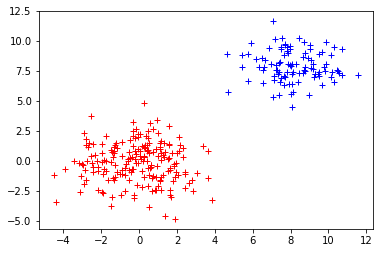

In [22]:
# Show the two point clouds
plt.plot(reference_points[:, 0], reference_points[:, 1],'r+')
plt.plot(query_points[:,0], query_points[:, 1],'b+')
plt.show()

In [23]:
# Find the shortest distance using the proposed method
start_time = time.clock()
d1, reference_indices1, query_indices1 = find_shortest_distance(reference_points, query_points)
end_time = time.clock()
print("process_time: " + str(end_time - start_time))

d2, reference_idncies2, query_indices2 = find_shortest_distance(query_points, reference_points)
# Swap query and reference point clouds, the shortest distance should be the same
print(d1, d2)

process_time: 0.006232000000000237
4.243346781007501 4.243346781007501


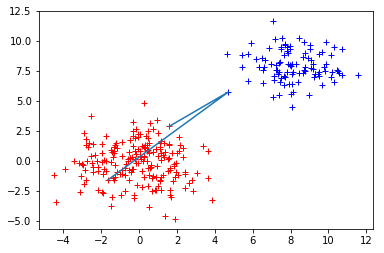

In [24]:
# Show the search path
def show_search_path(reference_points, reference_indices,
                     query_points, query_indices):
    x = []
    y = []
    for i in range(len(reference_indices)-1):
        # from ref to query
        x.append(reference_points[reference_indices[i]][0])
        y.append(reference_points[reference_indices[i]][1])
        x.append(query_points[query_indices[i]][0])
        y.append(query_points[query_indices[i]][1])
        # from query to ref
        x.append(query_points[query_indices[i+1]][0])
        y.append(query_points[query_indices[i+1]][1])
        x.append(reference_points[reference_indices[i+1]][0])
        y.append(reference_points[reference_indices[i+1]][1])
    plt.plot(reference_points[:, 0], reference_points[:, 1],'r+')
    plt.plot(query_points[:,0], query_points[:, 1],'b+')
    plt.plot(x, y)
    plt.show()

show_search_path(reference_points, reference_indices1, query_points, query_indices1)

In [25]:
# Find the shortest distance using the exhaustive search
start_time = time.clock()
d_exhaustive = find_shortest_distance(reference_points, query_points, 'exhaustive')
end_time = time.clock()
print("process_time: " + str(end_time - start_time))
print(d_exhaustive)

process_time: 0.024506999999999834
4.243346781007501
